In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
from pymsm.multi_state_competing_risks_model import PathObject, MultiStateModel
from pymsm.datasets import prep_ebmt_long
from pymsm.plotting import stackplot
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    plot_total_times_ecdf,
    make_states_at_timestep_array,
    path_to_timstep_array
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The EMBT dataset  
Data from the European Society for Blood and Marrow Transplantation (EBMT)  
  
  
A data frame of 2279 patients transplanted at the EBMT between 1985 and 1998.
(from R mstate package, see: https://www.rdocumentation.org/packages/mstate/versions/0.3.1/topics/EBMT%20data)  


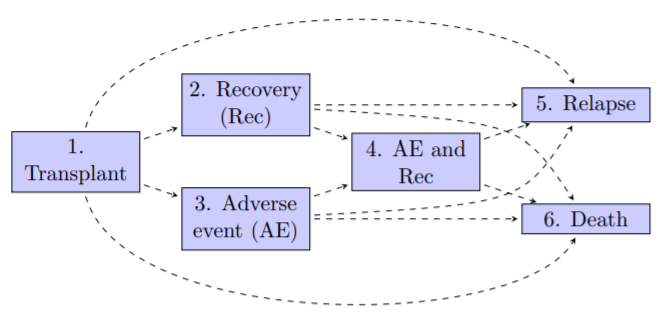

In [3]:
from IPython.display import Image

Image(filename="embt_states.png")


In [4]:
competing_risk_dataset, covariate_cols, states_labels = prep_ebmt_long()
competing_risk_dataset.head()


,sample_id,origin_state,target_state,time_entry_to_origin,time_transition_to_target,match_no gender mismatch,proph_yes,year_1990-1994,year_1995-1998,agecl_<=20,agecl_>40
0,1,1,2,0.0,22.0,1,0,0,1,0,0
1,1,2,0,22.0,995.0,1,0,0,1,0,0
2,2,1,3,0.0,12.0,1,0,0,1,0,0
3,2,3,4,12.0,29.0,1,0,0,1,0,0
4,2,4,5,29.0,422.0,1,0,0,1,0,0


# Peak at some transitions

/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


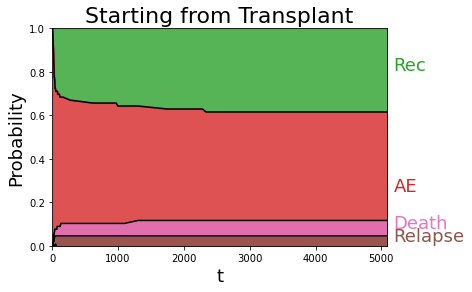

In [5]:
origin_state = 1
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[2, 3],
    order_bottom=[5, 6],
    labels=states_labels,
)


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


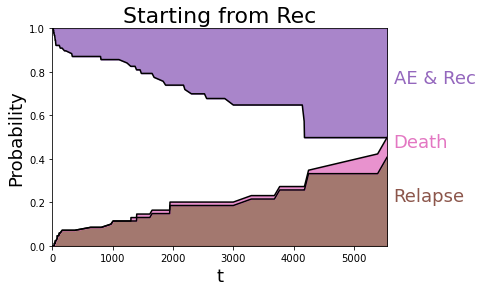

In [6]:
origin_state = 2
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[4],
    order_bottom=[5, 6],
    labels=states_labels,
)


# Fit MSM

In [7]:
def default_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    return covariates_entering_origin_state


terminal_states = [5, 6]


multi_state_model = MultiStateModel(
    competing_risk_dataset,
    terminal_states,
    default_update_covariates_function,
    covariate_cols,
    competing_risk_data_format=True,
)


multi_state_model.fit()


Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 785
>>> Fitting Transition to State: 3, n events: 907
>>> Fitting Transition to State: 5, n events: 95
>>> Fitting Transition to State: 6, n events: 160
Fitting Model at State: 2
>>> Fitting Transition to State: 5, n events: 112
>>> Fitting Transition to State: 6, n events: 39
>>> Fitting Transition to State: 4, n events: 227
Fitting Model at State: 3
>>> Fitting Transition to State: 4, n events: 433
>>> Fitting Transition to State: 6, n events: 197
>>> Fitting Transition to State: 5, n events: 56
Fitting Model at State: 4
>>> Fitting Transition to State: 5, n events: 107
>>> Fitting Transition to State: 6, n events: 137


# Single patient statistics

In [111]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=competing_risk_dataset.loc[0, covariate_cols],
    origin_state=1,
    current_time=0,
    n_random_samples=10,
    max_transitions=10,
)

for mc_path in mc_paths:
    states = mc_path.states
    time_at_each_state = mc_path.time_at_each_state
    print(states)
    print(time_at_each_state)


[1, 2, 4, 5]
[28.00006374299015, 3.999937915792742, 179.00002755568198]
[1, 2, 4, 6]
[36.00009461154621, 23.999964471779847, 49.00002128388163]
[1, 3, 5]
[23.00003274973522, 204.0000394954763]
[1, 2, 5]
[11.00009684887776, 89.99990315112224]
[1, 2, 5]
[33.000084435708274, 290.9999155642917]
[1, 3, 5]
[42.00005120930583, 4.000015948013726]
[1, 2, 5]
[25.00000894110023, 1923.9999910588997]
[1, 3, 5]
[22.000046369840494, 130.0000426565379]
[1, 2, 4, 6]
[35.00008925589985, 4.999992545576738, 1537.9999181985233]
[1, 3, 5]
[35.00000801148464, 333.9999919885154]


In [107]:
all_states = competing_risk_dataset["target_state"].unique()
# Probability of visiting any of the states
for state in all_states:
    if state == 0:
        continue
    print(
        f"Probabilty of {states_labels[state]} = {prob_visited_states(mc_paths, states=[state])}"
    )

# Probability of terminal states - Death and Relapse
print(
    f"Probabilty of any terminal state = {prob_visited_states(mc_paths, states=multi_state_model.terminal_states)}"
)



Probabilty of Rec = 0.59
Probabilty of AE = 0.31
Probabilty of AE & Rec = 0.74
Probabilty of Relapse = 0.24
Probabilty of Death = 0.76
Probabilty of any terminal state = 1.0


In [108]:
# Stats for times at states
dfs = []
for state in all_states:
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[states_labels[state]],
        )
    )
pd.concat(dfs)


,time_in_state_mean,time_in_state_std,time_in_state_median,time_in_state_min,time_in_state_max,time_in_state_quantile_0.1,time_in_state_quantile_0.25,time_in_state_quantile_0.75,time_in_state_quantile_0.9
Rec,43.659996,177.649042,5.999989,0.0,1514.999963,0.0,0.0,21.250038,52.999996
AE,33.679999,150.142456,0.000000,0.0,1368.000006,0.0,0.0,8.999978,52.600040
AE & Rec,1092.979978,1659.572735,161.999993,0.0,4760.999953,0.0,0.0,1427.749982,4213.399973


(-0.5, 100.0)

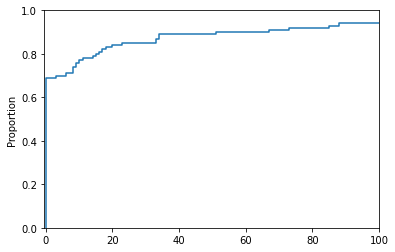

In [109]:
# CDF of  time in "adverse event" state
fig, ax = plt.subplots()
plot_total_times_ecdf(mc_paths, states=[3], ax=ax)
ax.set_xlim(-0.5, 100)



In [110]:
competing_risk_dataset[competing_risk_dataset["origin_state"] == origin_state].sample(
    10
)



,sample_id,origin_state,target_state,time_entry_to_origin,time_transition_to_target,match_no gender mismatch,proph_yes,year_1990-1994,year_1995-1998,agecl_<=20,agecl_>40
1661,815,2,0,23.0,1559.0,1,1,0,1,0,0
3169,1587,2,0,23.0,2217.0,1,0,1,0,0,0
2507,1270,2,0,29.0,4389.0,1,0,0,0,0,0
2470,1249,2,0,12.0,5393.0,1,0,0,0,0,0
1749,856,2,4,15.0,16.0,1,0,0,0,0,0
3235,1615,2,0,18.0,1125.0,1,0,0,1,0,1
3729,1854,2,5,25.0,133.0,1,0,1,0,0,0
4520,2230,2,0,21.0,192.0,1,0,0,1,1,0
3735,1857,2,4,27.0,35.0,1,0,0,1,0,1
2622,1319,2,0,23.0,280.0,1,0,0,1,0,0


In [195]:

states = [1, 2, 3]
time_at_each_state = [1.4, 1.7, 2.6]
max_timestep = 7
states_at_timestep = make_states_at_timestep_array(
    states, time_at_each_state, max_timestep, 0, True
)
assert (states_at_timestep == np.array([1, 2, 2, 3, 3, 3, 0])).all()



[1 2 2 3 3]
[1 2 2 3 3 3 0]
[1 1 1 0 0]
[1 2 2 5 5 5 5]
[1 2 2 3 3 3 0]


In [199]:
for mc_path in mc_paths:
    states = mc_path.states
    time_at_each_state = mc_path.time_at_each_state
    print(states)
    print(time_at_each_state)

[1, 2, 4, 5]
[28.00006374299015, 3.999937915792742, 179.00002755568198]
[1, 2, 4, 6]
[36.00009461154621, 23.999964471779847, 49.00002128388163]
[1, 3, 5]
[23.00003274973522, 204.0000394954763]
[1, 2, 5]
[11.00009684887776, 89.99990315112224]
[1, 2, 5]
[33.000084435708274, 290.9999155642917]
[1, 3, 5]
[42.00005120930583, 4.000015948013726]
[1, 2, 5]
[25.00000894110023, 1923.9999910588997]
[1, 3, 5]
[22.000046369840494, 130.0000426565379]
[1, 2, 4, 6]
[35.00008925589985, 4.999992545576738, 1537.9999181985233]
[1, 3, 5]
[35.00000801148464, 333.9999919885154]


In [212]:
max_timestep = 5
np.concatenate([[path_to_timstep_array(path, max_timestep)] for path in mc_paths])

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])